<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
    <p style="margin: 0; padding-top: 22px; text-align:right;"><b>Treball de Final de Màster </b></p>
<p style="margin: 0; text-align:right;"><b>ANÀLISI DEL DIA MUNDIAL DE LES MALALTIES MINORITÀRIES (Font de dades: TWITTER)</b>.</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Disseny i Implementació del TFM.

# Fase d'Anàlisi.
## Tèniques d'aprenentatge no supervisat per la detecció de comunitats i temàtiques.
### CLUSTERING - Algorisme DBSCAN.
<p style="color:#0000FF">
En aquest Jupyter Notebook, veurem com aplicar l'algorisme DBSCAN cercant els valors optims per els seus paràmetres.
    Apliquem l'algorisme sobre la matriu tfidf global i sobre la matriu de vectorització millorada ja considerada amb l'algorisme KMeans.
    <br>
    Les mesures d'optimització aplicades són:<br>
</p>    
    <ol style="color:#0000FF">
        <li>Agrupar tots els textos d'un mateix autor dels tuits, i reduïr el nombre de files de la matriu de vectorització.</li>
        <li>Filtrar les paraules o vocabulari inclos en la vectorització, aplicant els filtres de nombre mínim i màxim d'aparicions possibles en cada tuit global de cada usuari.</li>
    </ol>
<p style="color:#0000FF">    
    Utilitzem la representació vectorial de cada tuit, per tfidf obtenint una matriu de 12408 tuits (files) i 213 paraules (columnes).<br>
    Abans d'aplicar DBSCAN es calcula el valor òptim per el paràmetre 'eps'. Amb el valor de 'eps' trobem empíricament un valor per min_samples.
</p>

<ol style="color:#0000FF">
        <li><b>eps</b>: Radi que defineix la regió veïna a una observació (en anglès ϵ-neighborhoood)</li>
    <li><b>min_samples</b>: Nombre mínim d’observacions dins de la regió definida per el paràmetre 'eps'</li>
    </ol>


In [14]:
#llibreria numpy per usar la funció min().
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# Accés a la funció KMeans del mòdul cluster de la llibreria Skicit-learn.
from sklearn.cluster import KMeans, DBSCAN
# Visualització gràfica de matplotlib per Python.
import matplotlib.pyplot as plt
# Per el càlcul de durada dels processos.
import time
import delayedsparse
import scipy.sparse
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import re, collections
from textblob import TextBlob, Word
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.probability import FreqDist
import mpld3
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from itertools import cycle, islice
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

In [15]:
# Llegir el dataset
tuits = pd.read_excel("c:/users/qdeda/TFM_Code/DMMM_dataset_Final.xlsx")

In [16]:
# Transformacions:
t=tuits.drop(tuits[tuits.text_y.str.startswith('RT')].index)
# Juntem tuits d'un mateix autor.
t1 = t[['text_net','text_Norm','user_idstr']].groupby(['user_idstr']).agg(' '.join)
# Mitjana de polaritats i subjectivitats de tots els tuits
pol_subj = t[['user_idstr','polarity','subjectivity']].groupby(['user_idstr']).agg('mean')

# Eliminen paraules repetides
for row in t1.iterrows():
    tmp1=' '.join(set(row[1]['text_net'].split()))
    row[1]['text_net']=tmp1
    tmp2=' ' .join(set(row[1]['text_Norm'].split()))
    row[1]['text_Norm']=tmp2
# Reconstruim el dataset indexat per autor, perdem les identitats dels tuits
# tenim usuaris / paraules al construir el vector tfidf.
tuits = pd.merge(t1, pol_subj, left_on=t1.index, right_on=pol_subj.index, how='inner')
tuits.columns=['autor','text','text_norm','polaritat','subjectivitat']

# observem que les paraules obvies de hashtags queden per eliminar
excloure=['rare','day','today','february','disease','diseases','world']
for p in excloure:
    tuits.text=tuits.text.str.replace(p,"")
tuits.text

tuits=tuits.drop(tuits[tuits.text.str.len()==0].index)
tuits.reset_index(drop=True, inplace=True)
t=[]
t1=[]
t2=[]

In [17]:
tuits

,autor,text,text_norm,polaritat,subjectivitat
0,284633,idea visibilising little shitty understand ser...,vis ide shitty understand littl th behind febr...,-0.306944,0.622222
1,286543,niente,nient,0.000000,0.000000
2,610873,later organized develop run support game knows...,develop run support hap reorg network rar cut ...,0.178329,0.623134
3,627213,mast oh hey lolol checked ehlers mystery autoi...,mast oh hey lolol ehl mystery act neurolog fuc...,0.250000,0.650000
4,681573,count idiocracy,idiocr count diseas,0.000000,0.000000
...,...,...,...,...,...
12385,1235659467330641920,may god inshallah good health guide give continue,may god inshallah giv good heal guid continu,0.700000,0.600000
12386,1238808580419129088,video interesting thank much,video interest thank much,0.536250,0.455000
12387,1239512259027755008,infect thousands sanidad addition,infect addit thousand sanidad,0.000000,0.000000
12388,1243223320243441920,aww love bro lil,aww bro lov lil,0.400000,0.750000


In [18]:
# Paraules com rare, disease, february, world les eliminem
tuits.head()

,autor,text,text_norm,polaritat,subjectivitat
0,284633,idea visibilising little shitty understand ser...,vis ide shitty understand littl th behind febr...,-0.306944,0.622222
1,286543,niente,nient,0.000000,0.000000
2,610873,later organized develop run support game knows...,develop run support hap reorg network rar cut ...,0.178329,0.623134
3,627213,mast oh hey lolol checked ehlers mystery autoi...,mast oh hey lolol ehl mystery act neurolog fuc...,0.250000,0.650000
4,681573,count idiocracy,idiocr count diseas,0.000000,0.000000


In [37]:
tfidf_vect = TfidfVectorizer(min_df=0.01)
matriu_tfidf = tfidf_vect.fit_transform(tuits.text)
matriu_tfidf.shape

(12390, 221)

In [79]:
# Funció que fa la correspondència entre clústers de
# visualització i vectorització
def mappings(counts,model):
    vpca=counts.argsort()[::-1]
    vtf=np.bincount(model.labels_).argsort()[::-1]
    mapa = {}
    for key, val in zip(vpca, vtf):
        mapa[key] = val
    return mapa

# Funció per determinar el comportament de cada clúster obtingut.
def tokens_rel_mes_propers(mapa, model, vectorizer, mat_vect, topk=10):
#    Representació text dels primers-k mots més propers al seu centroide
#    model: model de sklearn escollit.
#    vectorizer: tipus de vectorització (tfidf)
#    topk: nombre de paraules k seleccionades per cluster
    nom_model = model.__class__.__name__
    paraules = vectorizer.get_feature_names()
    if nom_model is 'KMeans':
        grups=np.bincount(model.labels_)
        etq_rellevants = list(set(model.labels_))
        centroides = model.cluster_centers_.argsort()[:,::-1]
        for id_cluster in etq_rellevants:
            print('Cluster {}: '.format(id_cluster))
            for ind in centroides[mapa[id_cluster], :topk]:
                print(' {}'.format(paraules[ind]), end='')
            print()
            
def tokens_propers_dbscan(model, vectorizer, mat_vect, topk=10):
    relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
    paraules = vectorizer.get_feature_names()
    for this_label in relevant_labels:
        matching_rows = np.where(model.labels_ == this_label)[0]
        coeff_sums = np.sum(mat_vect[matching_rows], axis=0).A1
        sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
        print('Cluster {}: '.format(this_label), end='')
        for idx in sorted_coeff_idxs[:topk]:
            print('{} '.format(paraules[idx]), end='')
        print()
    

## Avaluem millor paràmetre 'eps' per DBSCAN


<p style="color:#0000FF">    
Cerquem el valor de 'eps' tal que minimitza la distància de cada punt als n punts més propers.
    Utilitzem l'algorisme <b>K Nearest Neighbors</b>, que ens proporciona els k veins més propers a un punt.</p>

In [167]:
# Visualitzacio amb PCA
Xz = matriu_tfidf
pca=delayedsparse.PCA(n_components=2)
X_PCA = pca.fit(Xz).transform(Xz)

In [168]:
neigh = NearestNeighbors(n_neighbors=2)
X=X_PCA
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

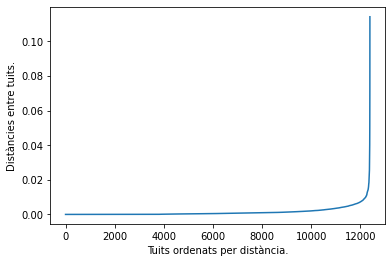

In [169]:
plt.figure(figsize=(6,4))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel("Tuits ordenats per distància.")
plt.ylabel("Distàncies entre tuits.")
plt.plot(distances)


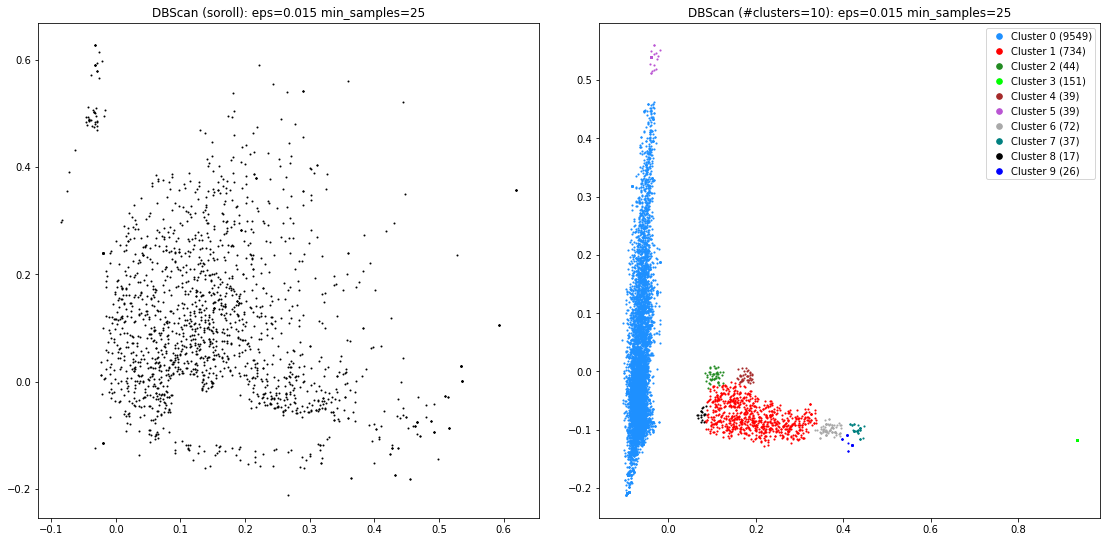

In [260]:
Xz=X_PCA
eps=0.015;  min_spl=25;
db_PCA = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db_PCA.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
plt.savefig("pca-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

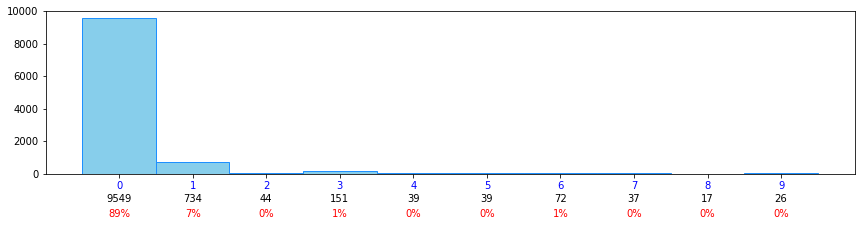

Nombre de tuits en el clúster més gran: 9549


In [261]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

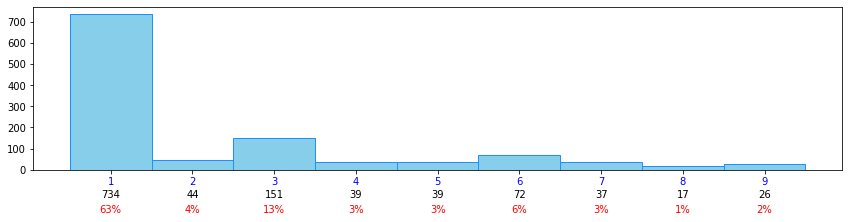

Nombre de tuits en el clúster més gran: 9549


In [262]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(1,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [263]:
tokens_propers_dbscan(db_PCA,tfidf_vect,matriu_tfidf,15)

Cluster 0: people research support patients one awareness us thank know many help tomorrow million like th 
Cluster 1: to celebrated every like also years year work research diagnosed make give syndrome good us 
Cluster 2: to awareness life year us special share st strong learn cure diagnosed know patients also 
Cluster 3: to yester hope helping help heard hear health hard happy group great good going go 
Cluster 4: to one families many awareness know syndrome see years make live fight help year spread 
Cluster 5: people million living wide know awareness raise around learn join tomorrow proud help support number 
Cluster 6: to stripes celebrating via remember news done say best different national two look first follow 
Cluster 7: to celebrate want read see important need hope new story take children family please also 
Cluster 8: to still time week us diagnosis celebrate hope even year many research st let event 
Cluster 9: to celebrated international little good much yester going hel

# Cas matriu vectorització optimitzada

In [15]:
tfidf_vect = TfidfVectorizer(min_df=0.01)
matriu_tfidf = tfidf_vect.fit_transform(tuits.text)
matriu_tfidf.shape

(12390, 221)

In [16]:
neigh = NearestNeighbors(n_neighbors=2)
X=matriu_tfidf
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

Text(0, 0.5, 'Distàncies entre tuits.')

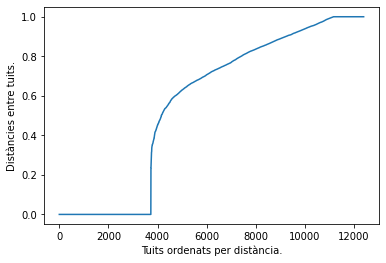

In [17]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel("Tuits ordenats per distància.")
plt.ylabel("Distàncies entre tuits.")

In [162]:
# Visualitzacio amb PCA
Xz = matriu_tfidf
pca=delayedsparse.PCA(n_components=2)
X_PCA_opt = pca.fit(Xz).transform(Xz)

In [163]:
neigh_opt = NearestNeighbors(n_neighbors=2)
X=X_PCA_opt
nbrs_opt = neigh_opt.fit(X)
distances_opt, indices_opt = nbrs_opt.kneighbors(X)

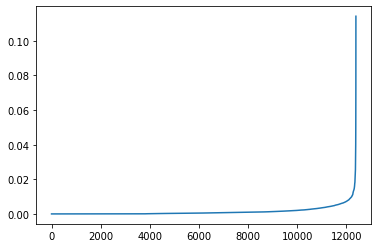

In [164]:
distances_opt = np.sort(distances_opt, axis=0)
distances_opt = distances_opt[:,1]
plt.plot(distances_opt)
plt.xlabel("Tuits ordenats per distància.")
plt.ylabel("Distàncies entre tuits.")

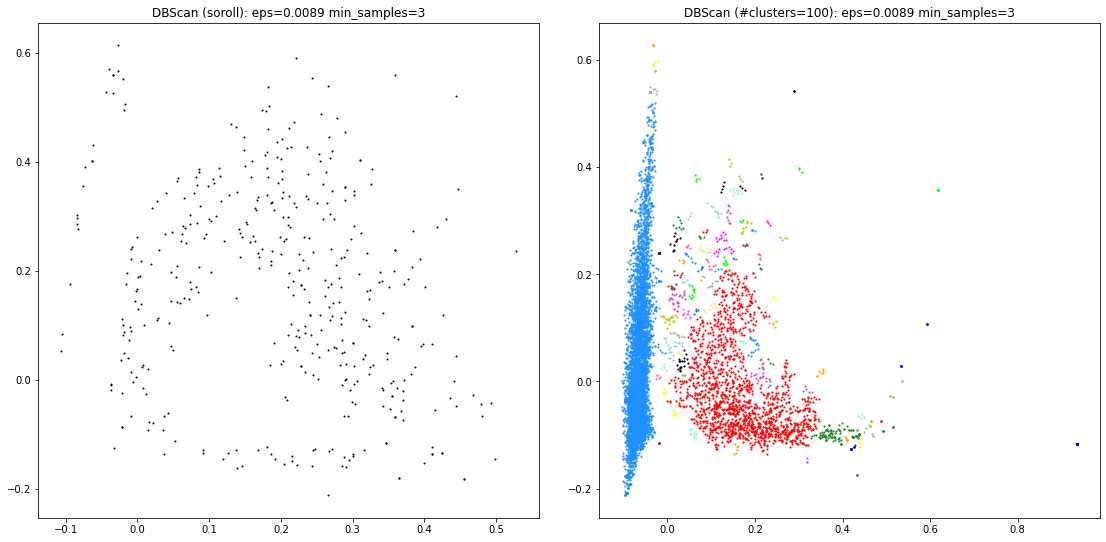

In [264]:
Xz=X_PCA
eps=0.0089;  min_spl=3;
db_PCA = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db_PCA.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
#ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
#plt.savefig("pca-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

In [252]:
tokens_propers_dbscan(db_PCA,tfidf_vect,matriu_tfidf,15)

Cluster 0: people research support one patients awareness us know thank many help million tomorrow like th 
Cluster 1: to awareness support us patients every research know learn one many year help raise also 
Cluster 2: to celebrate stripes celebrating want read via little remember done say best different national two 
Cluster 3: awareness to people raise lives support improve impact read living us point suffer symptoms public 
Cluster 4: year to yester go helping help heard hear health hard happy group great good going 
Cluster 5: to one awareness suffer raising living know take cure let hope children wide find learn 
Cluster 6: million one people fighting find helping help heard hear health hard happy group great good 
Cluster 7: people to less disorder would genetic wide like living research many know one us friends 
Cluster 8: to us share see awareness life help spread supporting sharing still thank hard advocate great 
Cluster 9: to yester hope helping help heard hear health hard 

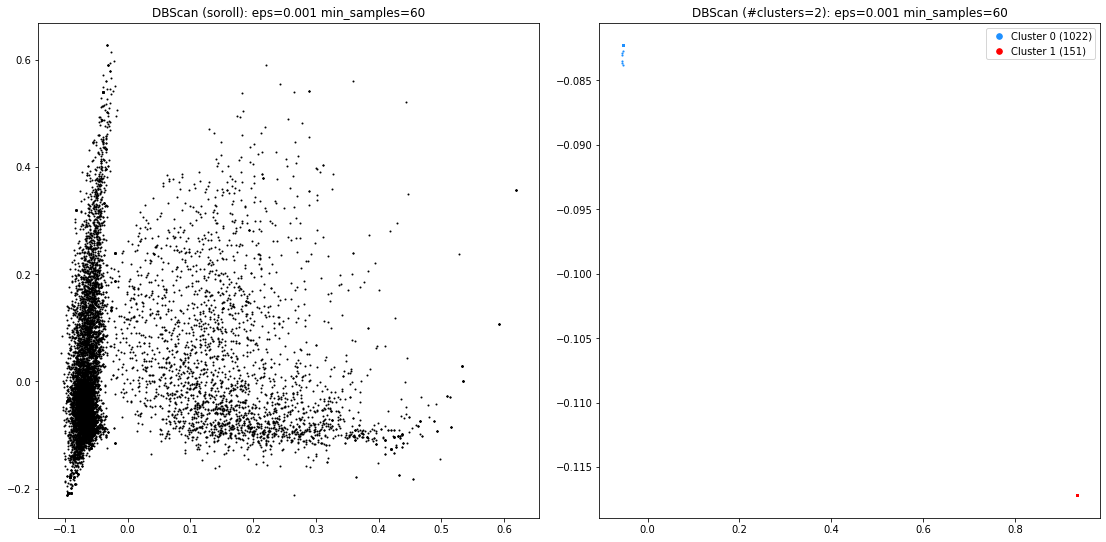

In [265]:
Xz=X_PCA
eps=0.001;  min_spl=60;
db_PCA = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db_PCA.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
#plt.savefig("pca-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

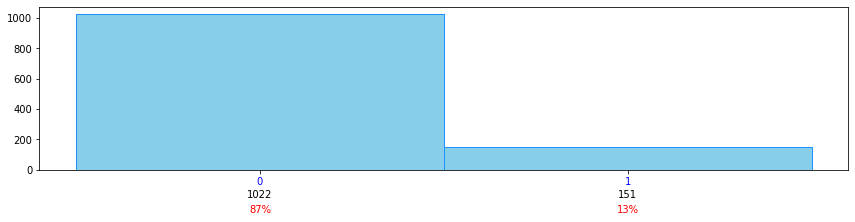

Nombre de tuits en el clúster més gran: 1022


In [266]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [268]:
tokens_propers_dbscan(db_PCA,tfidf_vect,matriu_tfidf,15)

Cluster 0: international different alone national disorders celebrating little go important meet understand journey involved well celebrate 
Cluster 1: to yester hope helping help heard hear health hard happy group great good going go 


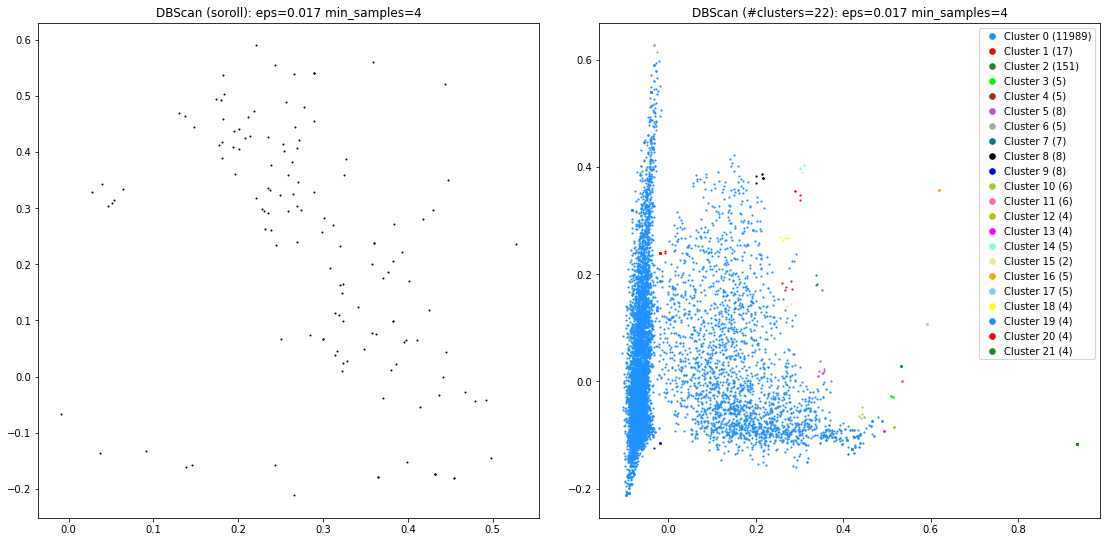

In [269]:
Xz=X_PCA
eps=0.017;  min_spl=4;
db_PCA = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db_PCA.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
#plt.savefig("pca-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

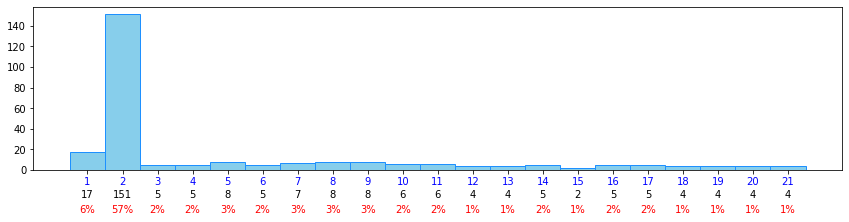

No es considera el clúster 0, Nombre de tuits en el clúster més gran: 11989


In [272]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(1,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("No es considera el clúster 0, Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [273]:
tokens_propers_dbscan(db_PCA,tfidf_vect,matriu_tfidf,15)

Cluster 0: to people awareness support one research patients us know million many thank help tomorrow like 
Cluster 1: raise awareness members better family wide genetic community together great find living million one point 
Cluster 2: to yester hope helping help heard hear health hard happy group great good going go 
Cluster 3: to know patients go help heard hear health hard happy group great good going yester 
Cluster 4: to raise awareness million one called impact show diagnosed diagnosis every help support patients genetic 
Cluster 5: to show one support even around together proud live families know patients us awareness friends 
Cluster 6: million people living one find good helping help heard hear fighting health hard happy group 
Cluster 7: one to hope helping help heard hear health hard happy group great good going go 
Cluster 8: living st people to families year raise awareness around million event share suffering tomorrow one 
Cluster 9: celebrated years illness honor helpin

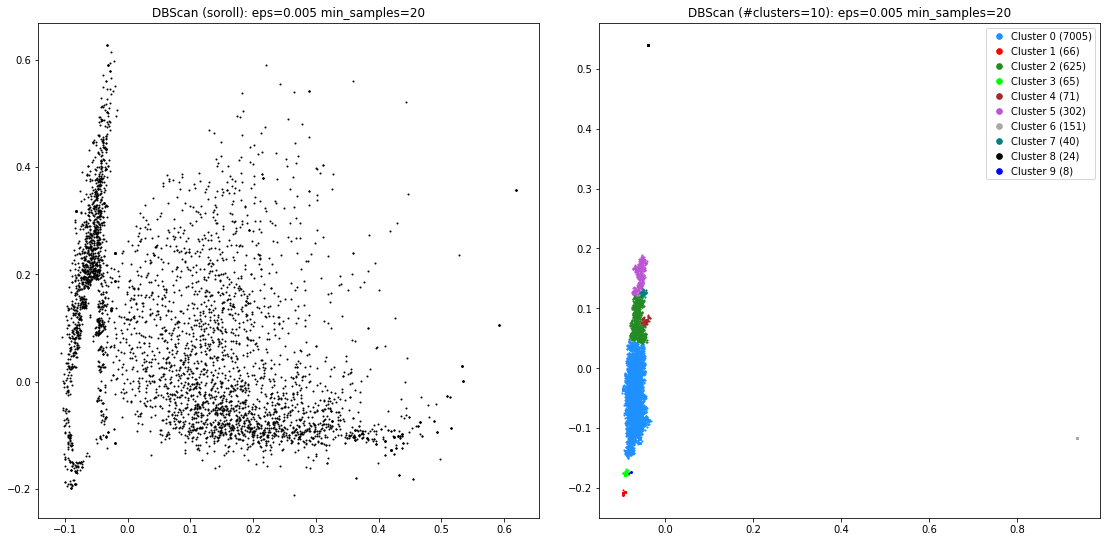

In [274]:
Xz=X_PCA
eps=0.005;  min_spl=20
db_PCA = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db_PCA.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
#plt.savefig("pca-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

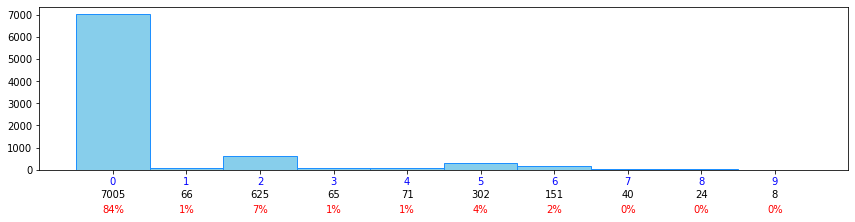

No es considera el clúster 0, Nombre de tuits en el clúster més gran: 7005


In [275]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("No es considera el clúster 0, Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [276]:
tokens_propers_dbscan(db_PCA,tfidf_vect,matriu_tfidf,20)

Cluster 0: research us patients know happy like tomorrow many great work support thank life syndrome th help one years also see 
Cluster 1: latest thanks daily thank syndrome going help heard hear health hard happy group great good global go give get genetic 
Cluster 2: support awareness people one living raise patients help us every families know proud many raising research wide like million please 
Cluster 3: thank daily latest thanks great happy everyone news cure forward satur good go think children common last health let life 
Cluster 4: one awareness raising raise children st year care satur th want last important join wide celebrate sharing make help common 
Cluster 5: people awareness raise million living affects know one support every lives affected patients many diagnosed tomorrow help disorder affect learn 
Cluster 6: to yester hope helping help heard hear health hard happy group great good going go global give get genetic full 
Cluster 7: awareness raise last public impact 

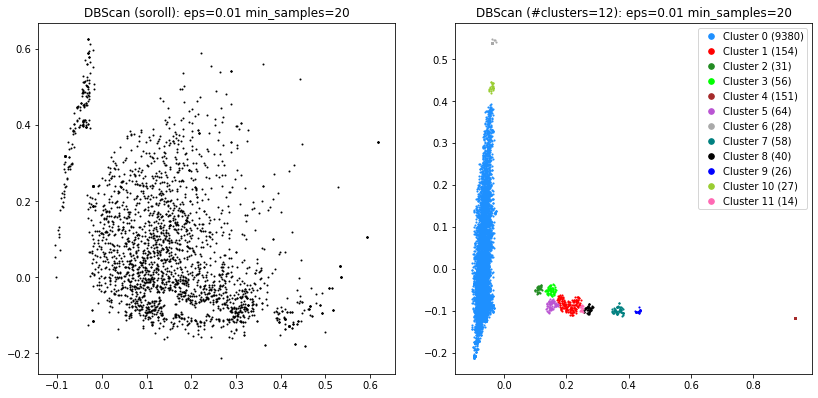

In [277]:
Xz=X_PCA
eps=0.01;  min_spl=20
db_PCA = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA.labels_))-1
matV=pd.DataFrame(X_PCA,columns=['x','y'])
matV['cluster']=db_PCA.labels_
fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=5, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
#plt.savefig("pca-DBSCAN_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

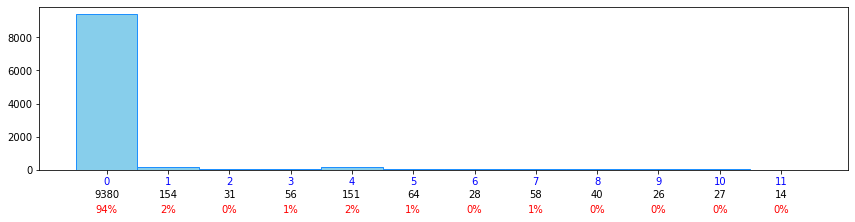

No es considera el clúster 0, Nombre de tuits en el clúster més gran: 9380


In [278]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

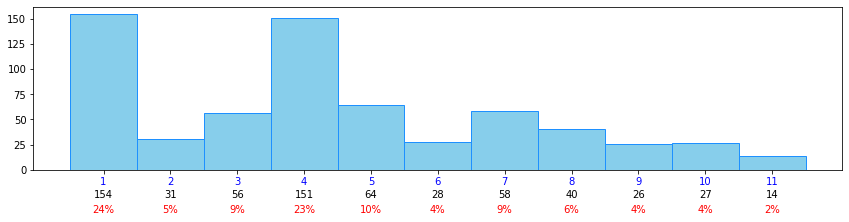

No es considera el clúster 0, Nombre de tuits en el clúster més gran: 9380


In [279]:
model=db_PCA
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(1,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("No es considera el clúster 0, Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [280]:
tokens_propers_dbscan(db_PCA,tfidf_vect,matriu_tfidf,20)

Cluster 0: people research support patients one us awareness thank know many help tomorrow like thanks life th every happy work year 
Cluster 1: to diagnosed see give every year also work like everyone make time video celebrate international illness want information look still 
Cluster 2: to life also patients th like treatments year time family us please work attention fight called others amazing help research 
Cluster 3: to every year family many one like also learn condition syndrome help years patients us affects would research know new 
Cluster 4: to yester hope helping help heard hear health hard happy group great good going go global give get genetic full 
Cluster 5: to give illness good well syndrome known make little like research lot us we health take still important diagnosed time 
Cluster 6: people million wide living know learn raise awareness around many live impact lives help global health hard little happy group 
Cluster 7: to stripes celebrating via remember done say b

# Conclusions cas optimitzat
<p style="color:#0000FF">
Hem vist com DBSCAN ens detecta bé els clusters, però com els tenim de diferents densitats ens cal configurar els paràmetres eps i min_samples per
    detectar els clústers amb cada tipus de densitat. Tot i això en la darrera visualització s'ha seleccionat una configuració equilibrada de manera
    que tot i existir clústers diferents es podem associar perquè les temàtiques de no detall són properes.
</p>

# Cas Anàlisi de Sentiment

In [193]:
# filtrem aquells tuits amb subjectivitat >0.5, tant per els tuits positius com negatius.
tuits_subj=tuits[tuits.subjectivitat>0.5]
tuits_subj.shape

(6461, 5)

### CAS DE TUITS A FAVOR

In [194]:
# tuits subjectius positivament.
tuits_pos=tuits_subj[tuits_subj.polaritat>=0.5]
print(tuits_pos.shape)

(962, 5)


In [195]:
# Vectorització dels tuits a favor.
tfidf_vect_pos = TfidfVectorizer()
matriu_tfidf_pos = tfidf_vect_pos.fit_transform(tuits_pos.text)

In [196]:
# Dimensions de la matriu Tf-idf dels tuits a favor
print(matriu_tfidf_pos.shape)

(962, 2848)


In [197]:
Xz = matriu_tfidf_pos
pca=delayedsparse.PCA(n_components=2)
X_PCA_pos = pca.fit(Xz).transform(Xz)

In [198]:
neigh_pos = NearestNeighbors(n_neighbors=2)
X=X_PCA_pos
nbrs_pos = neigh_pos.fit(X)
distances_pos, indices_pos = nbrs_pos.kneighbors(X)

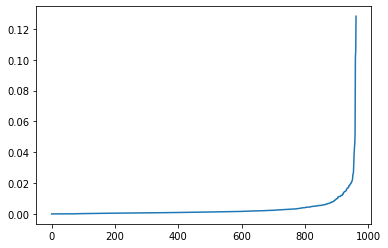

In [199]:
distances_pos= np.sort(distances_pos, axis=0)
distances_pos = distances_pos[:,1]
plt.plot(distances_pos)

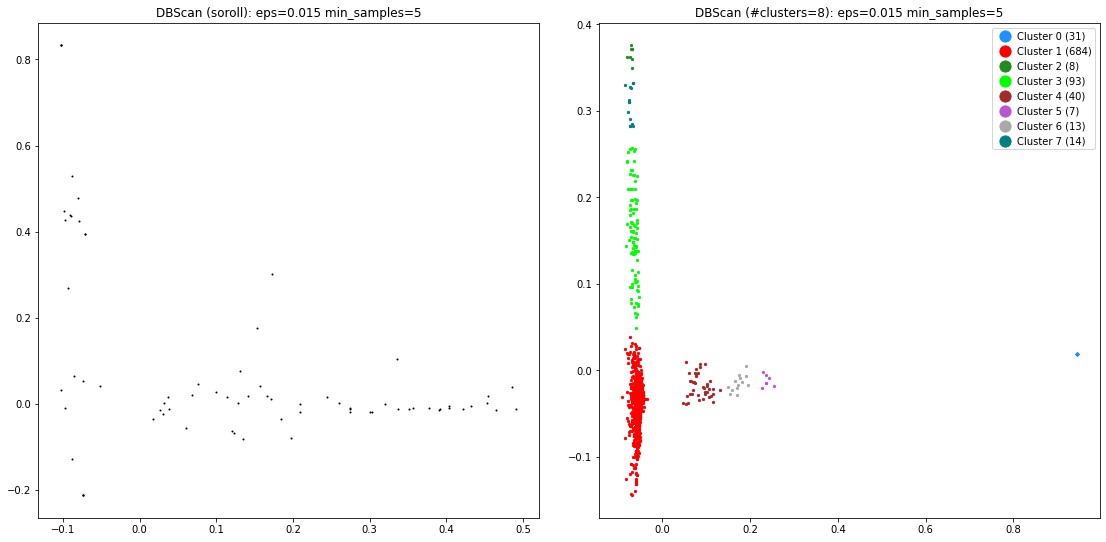

In [204]:
Xz=X_PCA_pos
eps=0.015;  min_spl=5;
db_PCA_pos = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA_pos.labels_))-1
matV=pd.DataFrame(X_PCA_pos,columns=['x','y'])
matV['cluster']=db_PCA_pos.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=20, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=5)
plt.savefig("pca-DBSCAN_pos_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

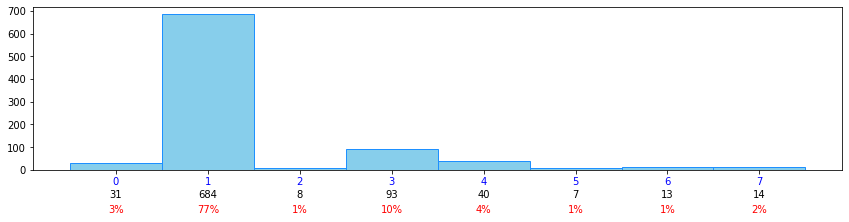

Nombre de tuits en el clúster més gran: 684


In [207]:
model=db_PCA_pos
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
#plt.savefig("histograma_DBSCAN_PCA_pos_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [206]:
tokens_propers_dbscan(db_PCA_pos,tfidf_vect_pos,matriu_tfidf_pos,15)

Cluster 0: happy áras follow forefront forces force for football food following followers folk forget focused focus 
Cluster 1: great to good love amazing beautiful thank uncommon people work awareness wonderful latest see important 
Cluster 2: proud stand pride anna anything something strong affected trialcard million many group research support football 
Cluster 3: proud work to support awareness us join patients community families wide help every treatments raise 
Cluster 4: happy fri see research life know to us makes fellow type year check hard never 
Cluster 5: happy celebrate couple overjoyed documenting biogen neuromyotonia probably maha everybody dia experience take glad able 
Cluster 6: happy fellow bold princesses ending remission baby genetically mutated sleepy af entities equalcare leapyear deserving 
Cluster 7: proud support patients dyskinesieciliaireprimitive labmates strong part students russell living many mateo helps cares company 



DBSCAN: (962, 2) 
 Durada:  0 minut/s  0 segons.


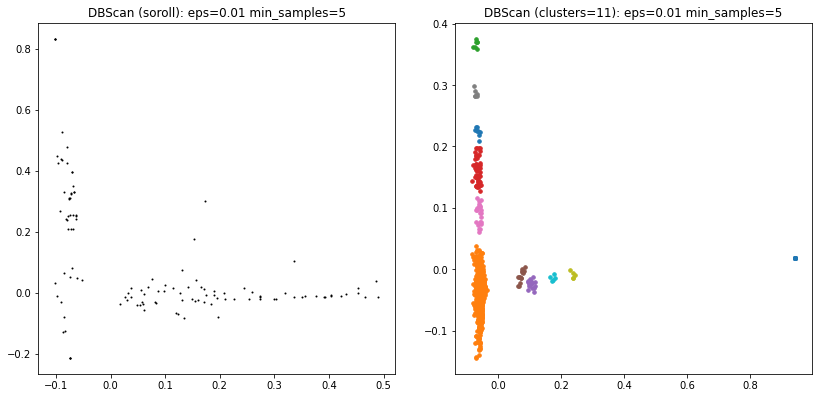

In [281]:
# Entrenem el model DBSCAN amb les dades Normalitzades         
time_start = time.time()
Xz=X_PCA_pos
eps=0.01;  min_spl=5
db_PCA_pos = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
temps=(time.time()-time_start)/60
print("\nDBSCAN:",np.shape(Xz),"\n Durada: ",int(temps) if temps>0 else 0,"minut/s ", \
      int((temps-int(temps))*60),"segons.")
max(set(db_PCA_pos.labels_))
matV=pd.DataFrame(X_PCA_pos,columns=['x','y'])
matV['cluster']=db_PCA_pos.labels_

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (clusters={}): eps={} min_samples={}".format(max(db_PCA_pos.labels_)+1,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
etq_rellevants = list(set(db_PCA_pos.labels_[db_PCA_pos.labels_>-1]))
for num in etq_rellevants:
    ax[1].scatter(matV[matV.cluster==num].x,matV[matV.cluster==num].y, marker='.', \
                  s=50, cmap='Set1')
plt.show()

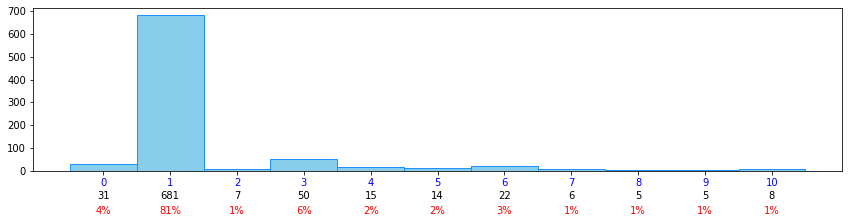

Nombre de tuits en el clúster més gran: 681


In [282]:
model=db_PCA_pos
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
#plt.savefig("histograma_DBSCAN_PCA_pos_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [283]:
tokens_mes_propers(db_PCA_pos,tfidf_vect_pos,matriu_tfidf_pos,15)

Cluster 0: happy áras follow forefront forces force for football food following followers folk forget focused focus 
Cluster 1: great to good love amazing beautiful people thank uncommon work wonderful awareness latest important awesome 
Cluster 2: proud stand anna anything something strong affected trialcard million many group research support fb force 
Cluster 3: proud awareness join us support million help patients raise work team to voice families tomorrow 
Cluster 4: happy see check life policy participation institutional hard tool badasses personally motor neurons kindergartner recovery 
Cluster 5: happy never us know within year three sight research fri told warriors patient fellow friends 
Cluster 6: proud although congenital get son community awareness to time president cmn embrace naevus melanocytic love 
Cluster 7: proud students russell mateo cares company support upcoming friend always strong amazing conditions showing honor 
Cluster 8: happy celebrate overjoyed biogen pro

### CAS DE TUITS EN CONTRA

In [284]:
# tuits subjectius negativament.
tuits_neg=tuits_subj[tuits_subj.polaritat<-0.1]
tuits_neg.shape

(379, 5)

In [285]:
# Vectorització dels tuits en contra.
tfidf_vect_neg = TfidfVectorizer()
matriu_tfidf_neg = tfidf_vect_neg.fit_transform(tuits_neg.text)

In [286]:
# Dimensions de la matriu Tf-idf dels tuits en contra.
print(matriu_tfidf_neg.shape)

(379, 1913)


In [287]:
Xz = matriu_tfidf_neg
pca=delayedsparse.PCA(n_components=2)
X_PCA_neg = pca.fit(Xz).transform(Xz)

In [288]:
neigh_neg = NearestNeighbors(n_neighbors=2)
X=X_PCA_neg
nbrs_neg = neigh_neg.fit(X)
distances_neg, indices_neg = nbrs_neg.kneighbors(X)

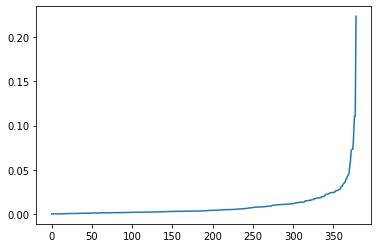

In [289]:
distances_neg = np.sort(distances_neg, axis=0)
distances_neg = distances_neg[:,1]
plt.plot(distances_neg)

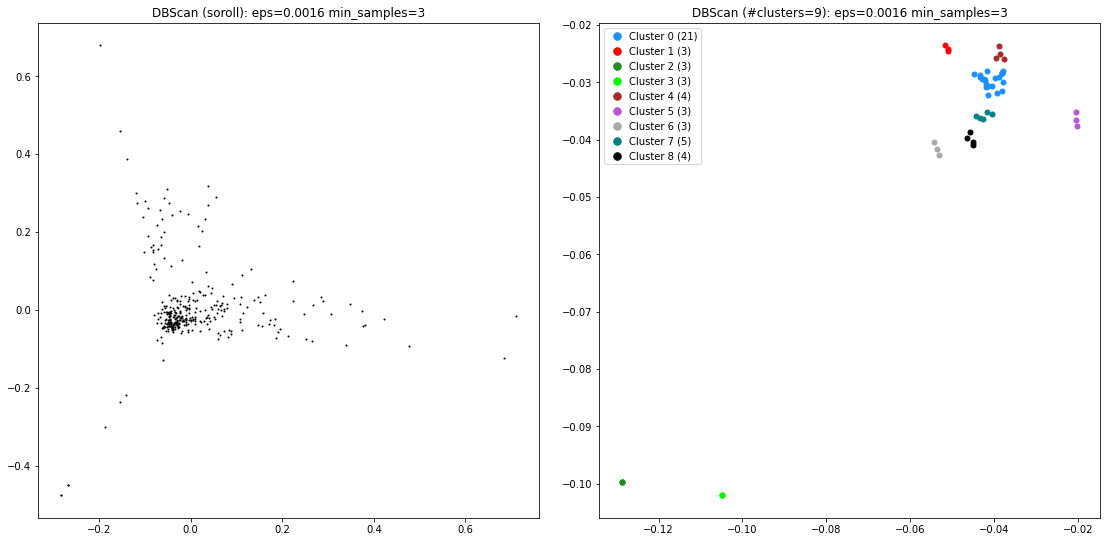

In [290]:
Xz=X_PCA_neg
eps=0.0016;  min_spl=3
db_PCA_neg = DBSCAN(eps=eps, min_samples=min_spl).fit(Xz)
num_clusters=len(set(db_PCA_neg.labels_))-1
matV=pd.DataFrame(X_PCA_neg,columns=['x','y'])
matV['cluster']=db_PCA_neg.labels_
fig, ax = plt.subplots(1,2,figsize=(16,8))
fig.tight_layout(pad=3.0)
# Visualitzem la gràfica de punts amb la funció scatter
ax[0].set_title("DBScan (soroll): eps="+str(np.round(eps,4))+" min_samples="+str(min_spl),fontsize=12)
colors = np.array(list(islice(cycle(['dodgerblue', 'red', 'forestgreen',
                                     'lime', 'brown', 'mediumorchid',
                                     'darkgrey', 'teal', 'black',
                                     'blue','yellowgreen','hotpink','y',
                                     'magenta','aquamarine','khaki',
                                     'orange','skyblue','yellow']),
                                      num_clusters)))
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=num_clusters-1)
ax[0].scatter(matV[matV.cluster==-1].x,matV[matV.cluster==-1].y, marker='o', s=1, c='black')
# Definim el títol de la gràfica
ax[1].set_title("DBScan (#clusters={}): eps={} min_samples={}".format(num_clusters,np.round(eps,4),min_spl),fontsize=12)
# Visualitzem el clustering realitzat per l'algorisme DBSCAN
for idcluster in range(num_clusters):
    ax[1].scatter(matV[matV.cluster==idcluster].x,matV[matV.cluster==idcluster].y, marker='.', s=100, \
                  c = colors[idcluster], norm=norm, cmap=cmap, label="Cluster {} ({})".format(idcluster, np.sum(matV.cluster==idcluster)))
ax[1].legend(handletextpad=0.2,borderpad=0.3,markerscale=1.5)
plt.savefig("pca-DBSCAN_neg_clusters={}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()

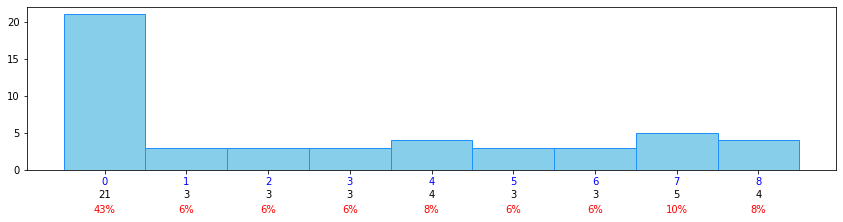

Nombre de tuits en el clúster més gran: 21


In [248]:
model=db_PCA_neg
num_clusters=len(set(model.labels_))-1
# Representació de l'histograma resultat del CLUSTERING.
fig, ax = plt.subplots(figsize=(14.5,3))
counts, bins, patches = plt.hist(model.labels_, bins=np.array(range(0,num_clusters+1)), facecolor='skyblue', edgecolor='dodgerblue')
# Configuració pel format dels eixos
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
# Definició de la posició i etiquetes de l'eix X.
ax.set_xticks(bin_centers)
ax.set_xticklabels(bins, rotation=0,color='b')
# Definició dels valors
for count, x in zip(counts.astype(int), bin_centers):
    # Etiquetes dels comptadors
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')
    # Etiquetes dels percentatges
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -35), textcoords='offset points', va='top', ha='center',c='r')
plt.savefig("histograma_DBSCAN_PCA_neg_0_{}.jpg".format(num_clusters),format='jpg',bbox_inches='tight')
plt.show()
print("Nombre de tuits en el clúster més gran: {}".format(np.bincount(model.labels_[model.labels_>-1]).max()))

In [249]:
tokens_propers_dbscan(db_PCA_neg,tfidf_vect_neg,matriu_tfidf_neg,15)

Cluster 0: crap wrong house played total aura come dies health migraine jets corrupt violent horrible obviously 
Cluster 1: breakdown amino prevents toxic acid phe extremely known brain fukuoka asia pacific japan individually meetup 
Cluster 2: socio problem sanitary serious frightening fought found foundation four framework france francis free freely friend 
Cluster 3: das hoxe nursities lunch ill ftd four framework france francis free freely friend friends frightening 
Cluster 4: unknown hurtful intention insecure deadly afro pif detected circumstances juncture reminding say expensive per may 
Cluster 5: fundamental makes appear physiotherapy suffers levels shocked cases high approximately three two okay happen afraid 
Cluster 6: half painful buzz tortures fault morning stress fucking sunflower serve newly aims nonprofit established student 
Cluster 7: stupid dissease pee chronic possible alcohol drunk without spherocytosis spleen hereditary anymore doctrine philosophies piles 
Clust

### Conclusions

<p style="color:#0000FF">
L'algorisme DBSCAN ens és molt útil per trobar clusters amb formes allardades o no convexes ni isotròpiques.
Tot i això, per trobar grups de clústers amb <b>densitats diferents</b>, no obtenim bons resultats globals. Només detectarem els d'un tipus segons configurem els paràmetres '<b>eps</b>' i '<b>min_samples</b>'.<br>
No és el cas, però si els grups de clusters fossin de la mateixa densitat, aleshores, ens seria molt més útil perquè a més a més ens separaria els tuits poc significatius com a soroll.<br>
    En el nostre cas, hem detectat molts grups dispersos amb diferents densitats cadascún i per els resultats de les proves realitzades identificar les temàtiques de detall ve determinat per una configuració específica dels paràmetres eps i min_samples. 
</p>

<p style="color:#0000FF">
Amb totes les proves realitzades veiem que el cas del dataset optimitzat, tots els algorismes ens donen una estimació d'entre 13 o 15 clústers. <br>
Ens queda per aplicar el dataset a algorismes de tipus jeràrquic aglomeratiu.
</p>